# Задача обработки последовательности


Для начала вспомним, что основным подходом для работы с последовательностями до 2017 года (выхода оригинальной статьи про архитектуру «трансформер») было использование рекуррентных нейронных сетей, или RNN. Однако у такого подхода есть несколько известных минусов:

* Вся информация о последовательности хранится в скрытом состоянии, которое обновляется с каждым шагом.
* Обучение рекуррентных сетей сложно распараллелить: чтобы получить скрытое состояние RNN-слоя для шага i+1, вам необходимо вычислить состояние для шага i.

## Elman RNN (1990)

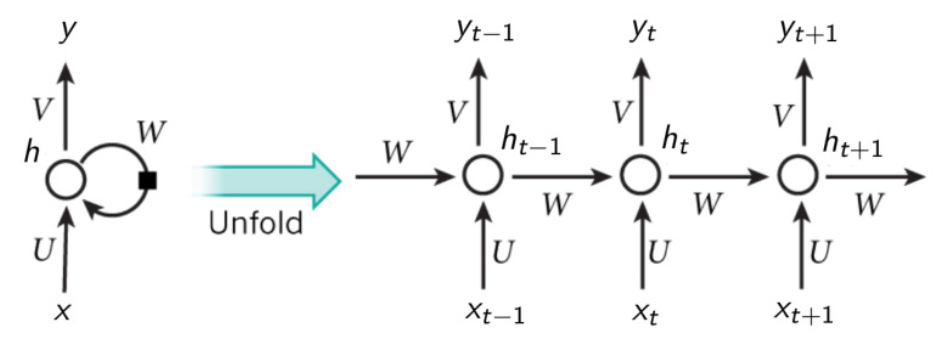

$$ h_t = \sigma \left( Ux_t + b_U+ Wh_{t-1} + b_W\right) $$
$$ y_t = \sigma \left( Vh_t + b_V\right) $$

Хочется иметь способ «читать» последовательность так, чтобы в каждый момент времени можно было обратиться к произвольному моменту из прошлого за константное время и без потерь информации. Таким способом и является лежащий в основе трансформеров механизм self-attention

## Seq2Seq RNN + Attention (2015)

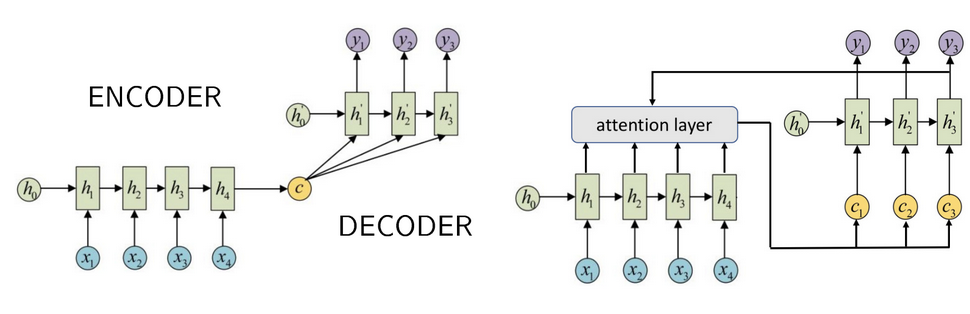

Механизм внимания вычисляет веса внимания $\alpha_{ti}$, которые показывают, насколько важно скрытое состояние $h_{i}$ энкодера для текущего шага декодера $t$.

$$\newcommand{\mathleft}{\@fleqntrue\@mathmargin0pt}
{
    h_i = f_{in}\left( x_i, h_{i-1} \right) \\
    α_{ti} = \frac{a \left( h_i, h^\prime_{t-1} \right)}{\sum_{k} a \left( h_k, h^\prime_{t-1} \right)} = norm_i a \left( h_i, h^\prime_{t-1} \right) \quad \text{--}  \quad \text{attention score} \\
    c_t = \sum_i \alpha_{ti} h_i \quad \text{--}  \quad \text{context vector} \\
    h^\prime_t = f_{out}\left( h^\prime_{t-1}, y_{t-1}, c_t \right) \\
    y_t = f_{y}\left( h^\prime_{t}, y_{t-1}, c_t \right)
}$$

Где $a \left( h, h^\prime \right)$ -- функция сходства состояния входа $h$ и выхода $h^\prime$.


*   $a \left( h, h^\prime \right) = h^\intercal h^\prime$
*   $a \left( h, h^\prime \right) = \exp \left( h^\intercal h^\prime \right)$
*   $a \left( h, h^\prime \right) = h^\intercal W h^\prime$

# Transformer

Ниже приведено устройство архитектуры «трансформер» из оригинальной [статьи](https://arxiv.org/pdf/1706.03762):

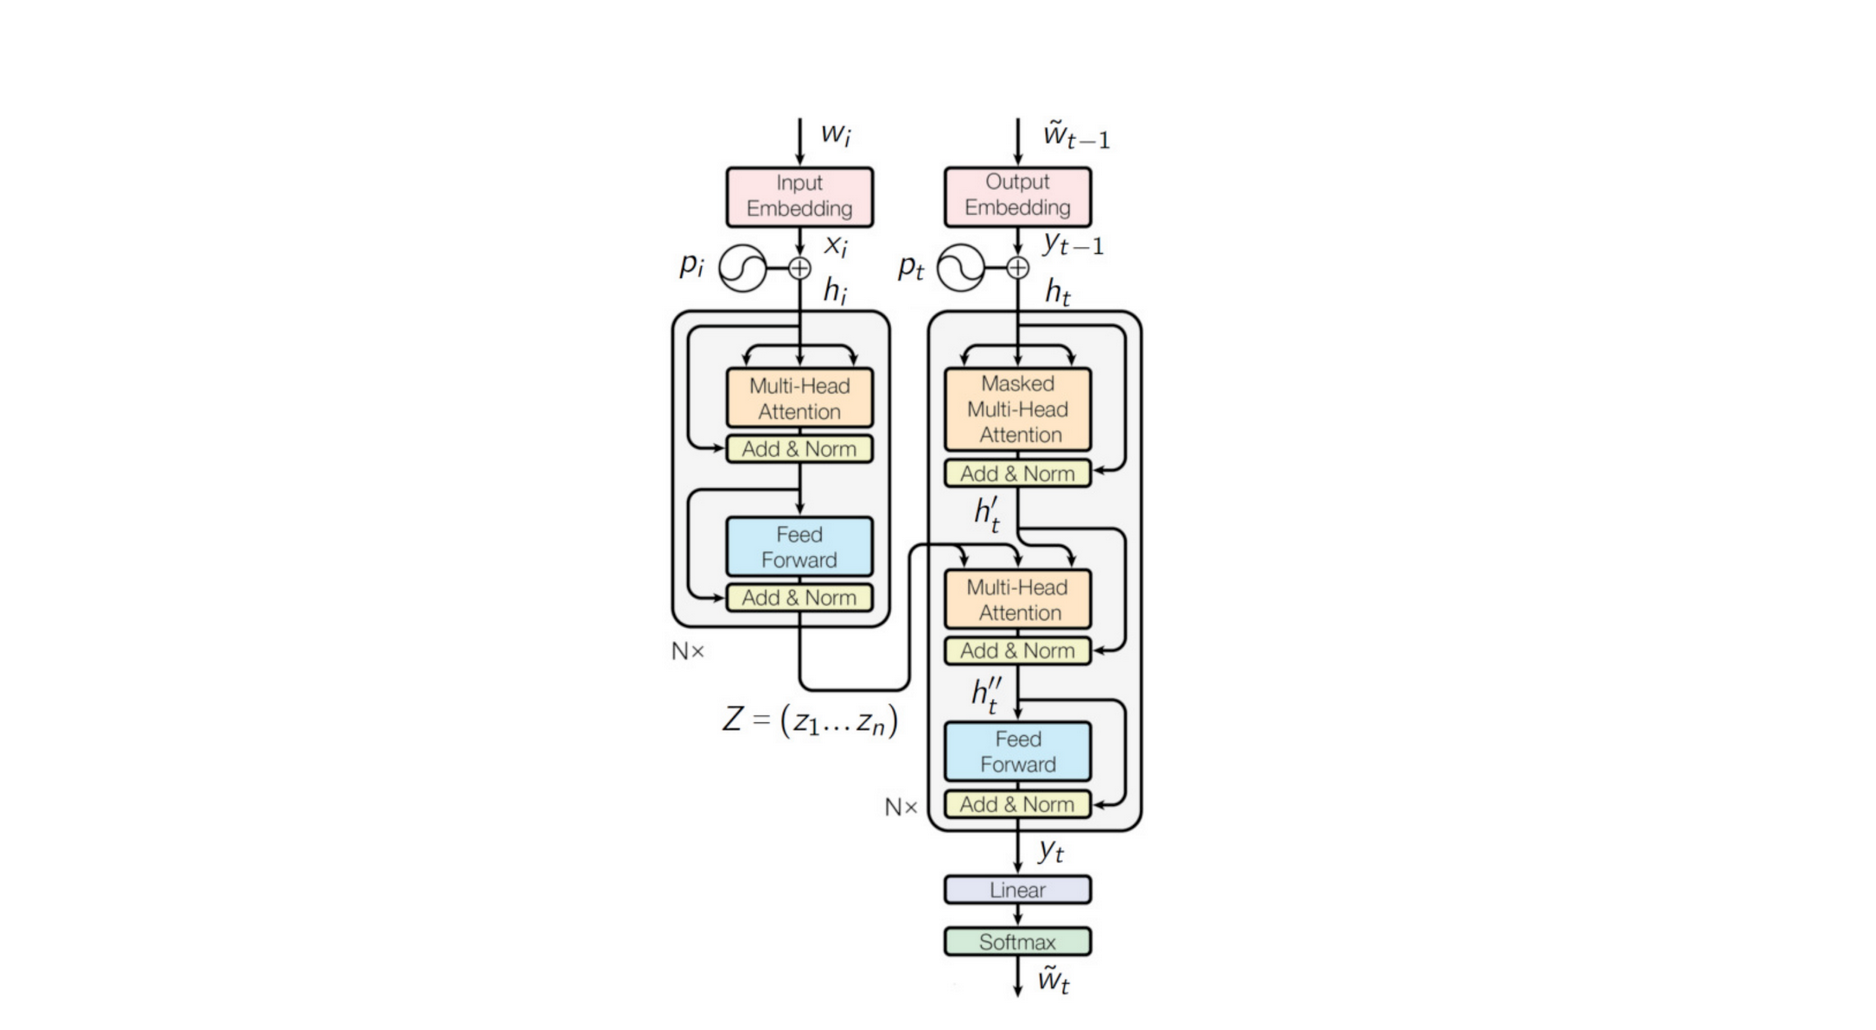

Стоит ознакомиться с разделом хэндбука от Яндекса: [Трансформеры](https://education.yandex.ru/handbook/ml/article/transformery)

## Обучаемое внимание (key, quary, value approach)


$$\newcommand{\mathleft}{\@fleqntrue\@mathmargin0pt}
{
    q_{t-1} = W_q h^\prime_{t-1} \qquad k_i = W_k h_i \qquad v_{i} = W_v h_i \\
    a \left( h_i, h^\prime_{t-1} \right) = k^\intercal_i q_{t-1} / \sqrt{d} \\
    \alpha_{ti} = SoftMax_i \, a \left( h_i, h^\prime_{t-1} \right) \\
    c_t = \sum_i \alpha_{ti} v_i
}$$


#### Как считать Self-Attention на практике

1. Можно не заводить отдельно три матрицы, поэтому можно сконкатенировать их в одну и посчитать все сразу:
$$
\hat W = [W_Q, W_K, W_V] \in ℝ^{H \times 3\hat H} \\
[Q,K,V] = \hat WX \\
Q,K,V = split([Q,K,V])
$$
На практике используется один слой Linear или одна матрица весов + reshape
2. Считать для каждой головы неоптимально, поэтому можно посчитать их одной матрицей через batched matmul
$$
reshape: Q,K,V \\
L\times H  ⟶ NH \times T \times H^{'} \\
scores = \frac{QK^T}{\sqrt d} \in NH \times T \times T
$$

где $NH$ - число голов

Отличие self-attention в **декодере**:
1. Этот слой получает на вход $K, V$ как результат работы энкодера
> $K^TV$ можно считать своеобразной базой данных, словарем, состоящим из ключа и значения, для которого мы делаем запрос
2. Чтобы слой не заглядывал в "будущее", применяется маскирование

Подробнее: [здесь](https://huggingface.co/blog/encoder-decoder)

### Виды внимания


*   **self-attention** - если $h^\prime_{t-1}  = h_t$
*   **masked self-attention** - тот же attention, но с маскированной частью входа
*   **multi-head attention** - если параллельно работает несколько голов внимания, а их вектора коонтекста как-либо "складываются"



#### Sparse Attention

В наивной постановке виден недостаток Self-Attention: слишком большая вычислительная сложность $O(T^2H)$ и сложность по памяти $O(T^2)$

Именно этот недостаток стремится исправить Sparse Attention:
1. Для большинства токенов $scores$ околонулевые
2. Ну так давайте не будем их считать и, возможно, хранить

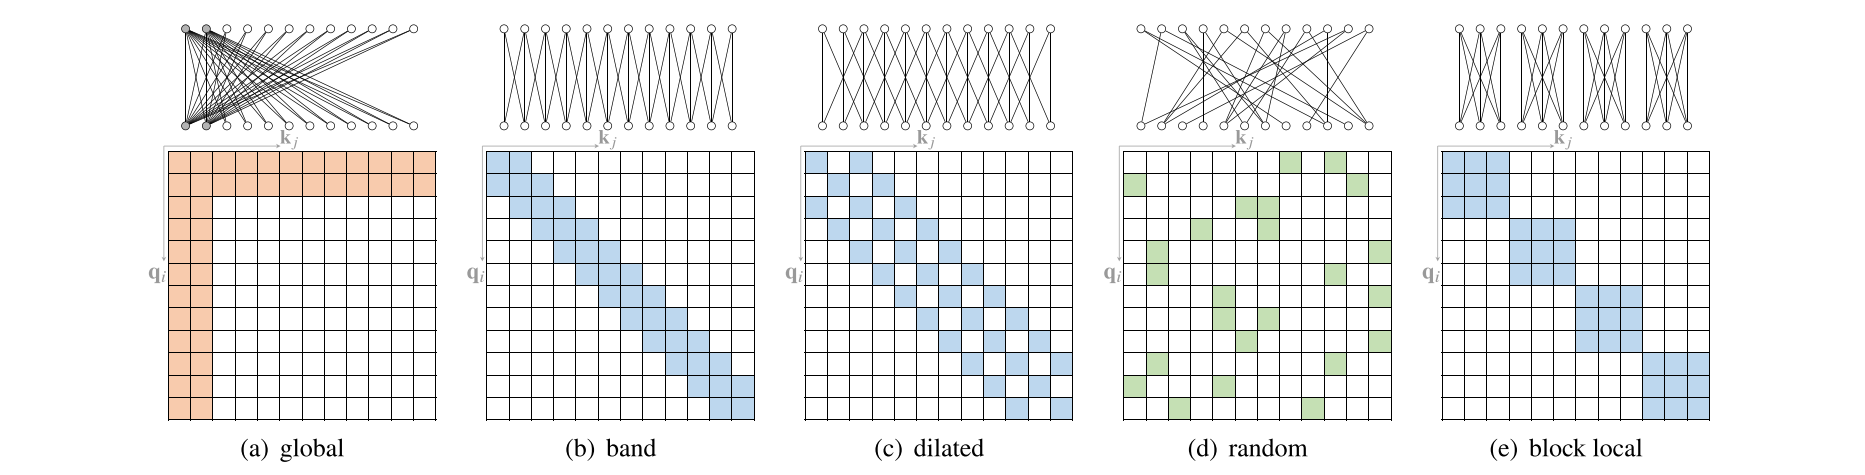

#### Flash Attention

* меньше чтений/записей в HBM
* параллелизации вычислений:
  - tiling: \( Q \), \( K \), \( V \) делятся на блоки, помещающиеся в RAM
  - Локальные softmax с коррекцией статистик.


[git](https://github.com/Dao-AILab/flash-attention)

In [ ]:
# Реальный Flash Attention использует рукописные ядра
def flash_attention(Q, K, V):
    for block_Q in Q:
        for block_K, block_V in zip(K, V):
            # Вычислить локальные scores
            S_block = block_Q @ block_K.T / sqrt(d_k)
            # Локальный softmax с коррекцией
            P_block = softmax(S_block)
            # Обновить выход блочно
            O += P_block @ block_V
    return O

## Positional encoding

В моделях типа Transformer (например, в BERT или GPT) отсутствует встроенная информация о порядке слов (в отличие от рекуррентных сетей). Чтобы модель понимала позицию слов в последовательности, используется **Positional Encoding** — специальное векторное представление, которое добавляется к эмбеддингам слов.

Позиции слов $i$ кодируются векторами $p_i$, $i=1,…,n$ и чем больше $|i-j|$, тем больше $\|p_i - p_j\|$
$$
p_{is} = \sin{i10^{-8\frac{s}{d}}} \quad p_{i, s+\frac{d}{2}} = \cos{i10^{-8\frac{s}{d}}}
$$

Примеры более современных способов позиционного кодирования : [Relative Position (2018)](https://arxiv.org/abs/1803.02155) и [RoPE (2021)](https://arxiv.org/abs/2104.09864)

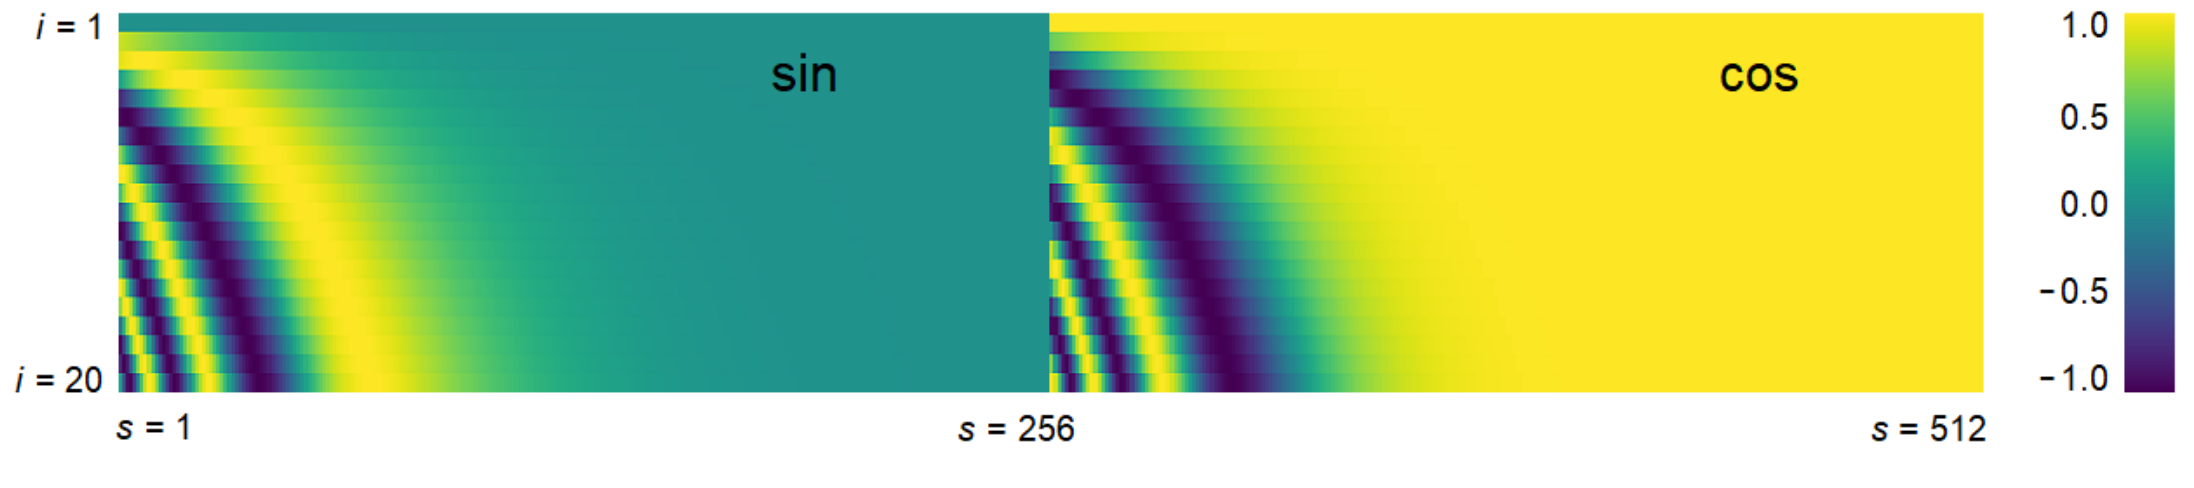

# BERT (2018) - encoder-only model

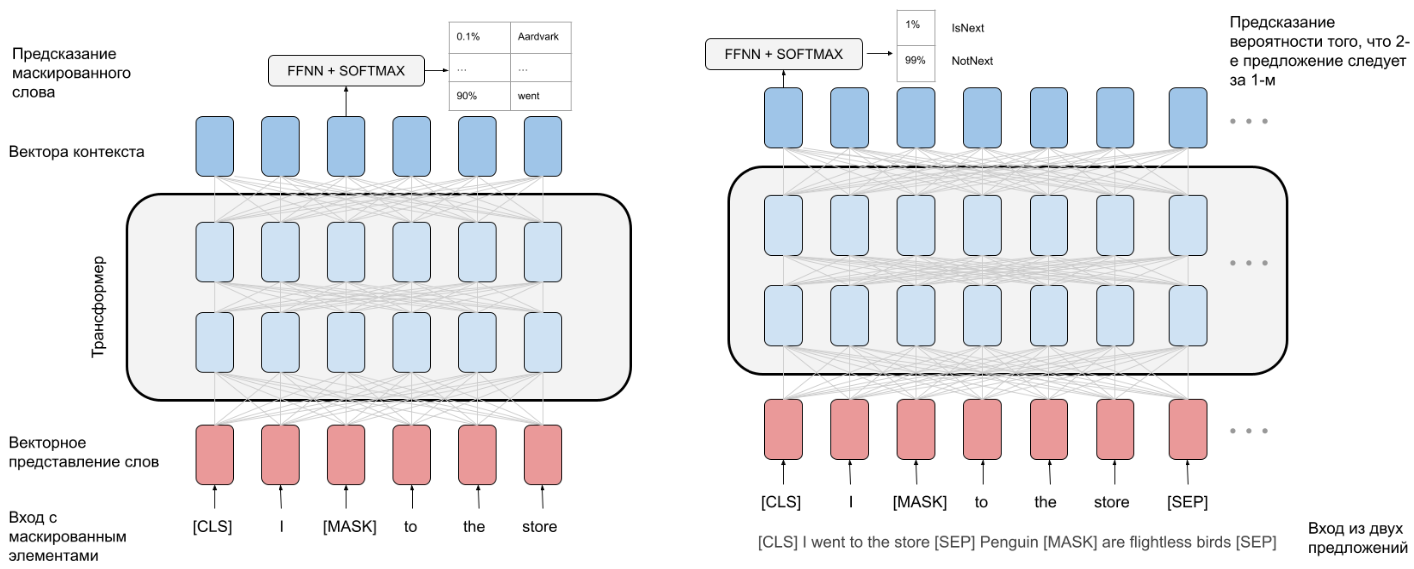

## BERT "понимает" грамматику и синтаксис языка

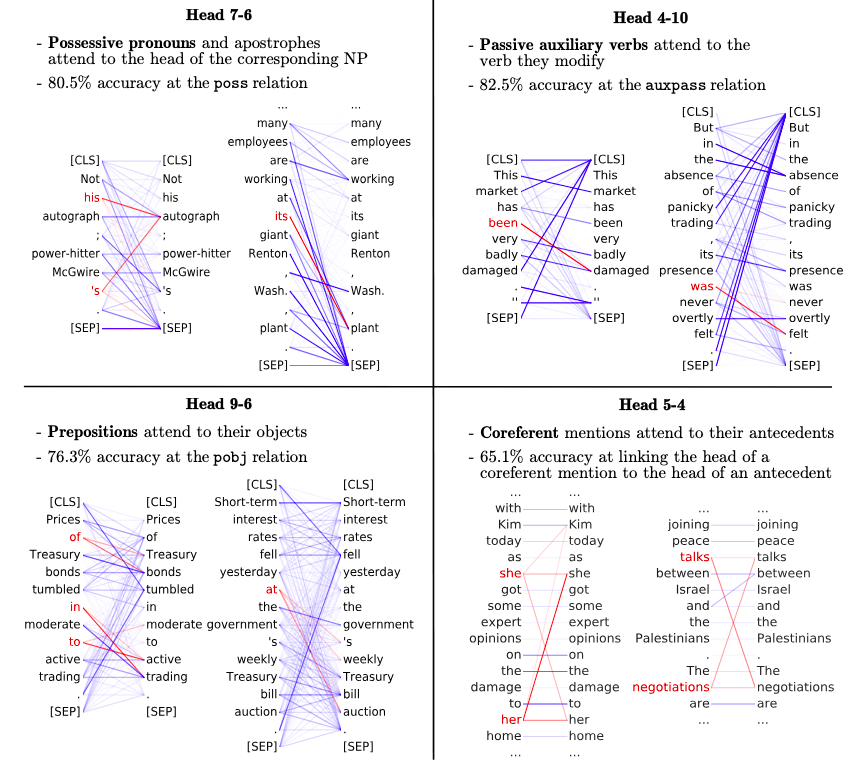

[What does BERT look at? An Analysis of BERT’s Attention / Clark et al. // 2019](https://aclanthology.org/W19-4828/)

Еще типы голов: позиционные, синтаксические, "rare token head"

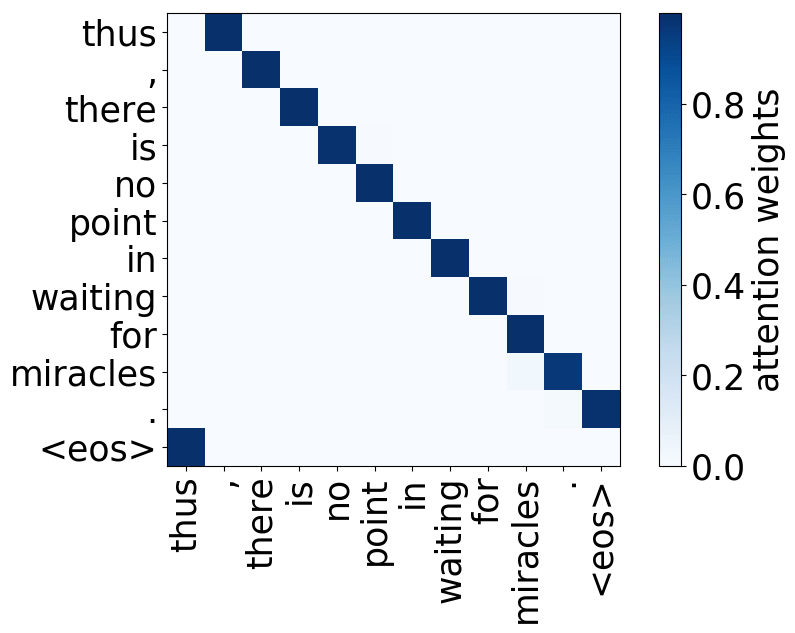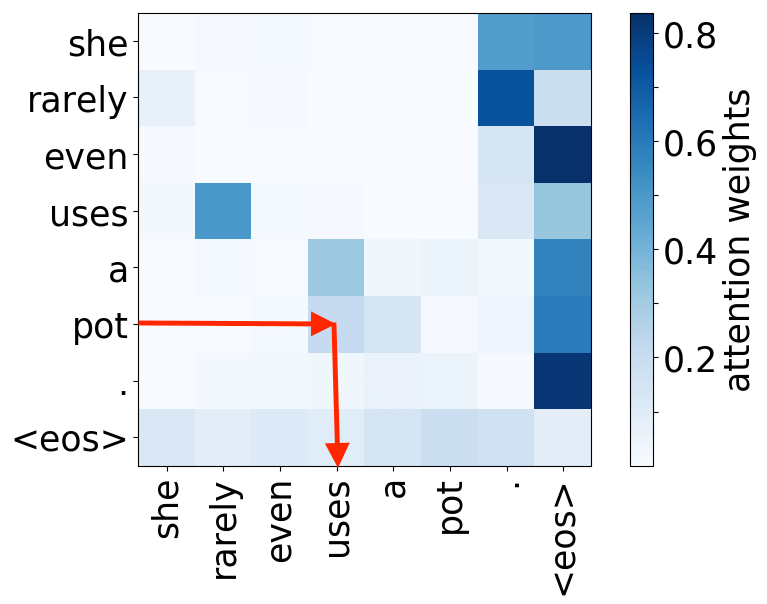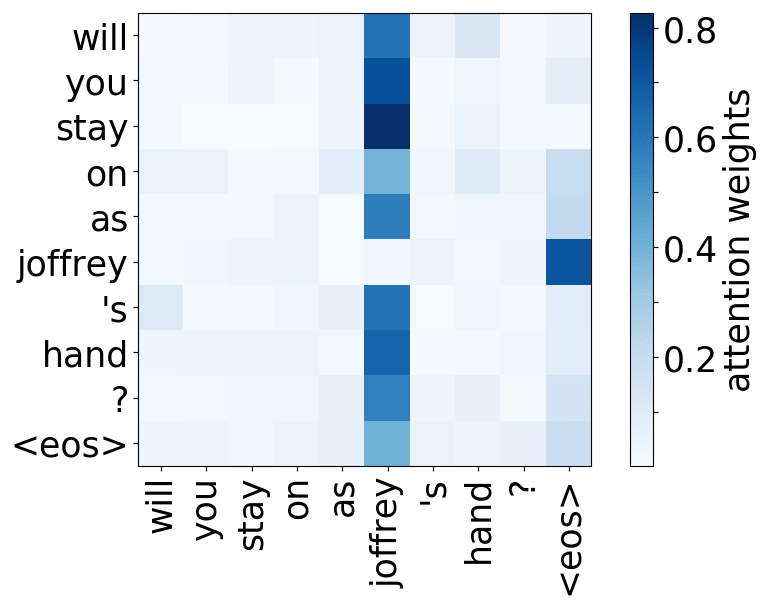

 [Analyzing Multi-Head Self-Attention: Specialized Heads Do the Heavy Lifting, the Rest Can Be Pruned.](https://www.aclweb.org/anthology/P19-1580.pdf)

# Практика

In [ ]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pya

In [ ]:
!pip install transformers -qq

In [ ]:
!pip install evaluate -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from typing import List, Tuple

In [ ]:
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import pipeline

# Pipeline дообучения модели

In [ ]:
SEED = 42

## Загрузим токенайзер

In [ ]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
seq = 'Привет о дивный новый мир!'
print(tokenizer.encode(seq))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(seq)))

[101, 77527, 612, 32136, 1916, 10303, 6913, 106, 102]
['[CLS]', 'Привет', 'о', 'див', '##ный', 'новый', 'мир', '!', '[SEP]']


## Загрузим данные

In [ ]:
DATASET_NAME = 'Davlan/sib200'
DATASET_LANGUAGE = 'rus_Cyrl'
train_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='train')
validation_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='validation')
test_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='test')

README.md: 0.00B [00:00, ?B/s]

train.tsv: 0.00B [00:00, ?B/s]

dev.tsv: 0.00B [00:00, ?B/s]

test.tsv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(train_set)

Dataset({
    features: ['index_id', 'category', 'text'],
    num_rows: 701
})


In [ ]:
DATASET_NAME = 'Davlan/sib200'
DATASET_LANGUAGE = 'rus_Cyrl'
raw_datasets = load_dataset(DATASET_NAME, DATASET_LANGUAGE)

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['index_id', 'category', 'text'],
        num_rows: 701
    })
    validation: Dataset({
        features: ['index_id', 'category', 'text'],
        num_rows: 99
    })
    test: Dataset({
        features: ['index_id', 'category', 'text'],
        num_rows: 204
    })
})

In [ ]:
raw_datasets["train"]["category"]

Column(['geography', 'science/technology', 'science/technology', 'entertainment', 'entertainment'])

In [ ]:
len(list(raw_datasets["train"]['category']))

701

In [ ]:
list_of_categories = sorted(list(
            set(raw_datasets["train"]["category"]) | set(raw_datasets["validation"]["category"]) |
            set(raw_datasets["test"]["category"])
        ))
indices_of_categories = list(range(len(list_of_categories)))

In [ ]:
list_of_categories

['entertainment',
 'geography',
 'health',
 'politics',
 'science/technology',
 'sports',
 'travel']

## Токенизируем тексты

In [ ]:
MINIBATCH_SIZE = 64
tokenized_train_set = train_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)
tokenized_validation_set = validation_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)

Map:   0%|          | 0/701 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_set)

Dataset({
    features: ['index_id', 'category', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 701
})


## Загрузим метрику для оценки качества модели на задаче классификации

### Метрики качества




1. Любая метрика, подходящая для классификации: для предсказания следующего токена мы оцениваем распределение вероятностей по всем токенам
2. Аппроксимированная кросс-энтропия: $$L(D) = -\sum_{d \in D} \log p(w_1, ..., w_k)$$
3. [Перплексия](https://habr.com/ru/companies/wunderfund/articles/580230/): $$P(D) = e^{-\frac{1}{|D|}L(D)}$$
То есть, число Эйлера в степени кросс-энтропии
  > Мера неопределенности, показывает, насколько модель не уверена в вероятности того или иного примера.

  > Например у последовательности "Мама мыла раму" будет низкая перплексия, потому что этот пример часто встречается в данных. А у "Кали мыла раму" - высокая. Вполне возможно, этот пример часто встречается в тексте

4. Внешние метрики качества - используем модель в задаче, смотрим на метрику качества в задаче.
  > Для предсказания поисковых подсказок можно смотреть на то, какой процент людей по ним переходит

**Перплексия** - наша основная метрика, ее можно использовать:
1. Для псевдоразметки данных
2. Как способ выбрать различные решения:
  > Есть вопрос:  
  > "*В каком году родился А.С. Пушкин?  
  > А. 1917, Б. 1799, В. 1657, Г. 1700.*"  
  
  > Тогда у варианта  
  > "*В каком году родился А.С. Пушкин?  
  > А. 1917, Б. 1799, В. 1657, Г. 1700. Ответ: Б. 1799*".  
  > Должна быть наименьшая перплексия
3. Как один из инструментов корпусной лингвистики для изучения закономерностей языка
4. Для промпт-инжениринга, ведь нормативные вопросы всегда будут с меньшей перплексией, чем вопросы с редкими словами, не проставленными знаками препинания, странными последовательностями знаков

In [ ]:
cls_metric = evaluate.load('f1')

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return cls_metric.compute(predictions=predictions, references=labels, average='macro')

## Создадим вспомогательный объект для трансформации данных в тензор

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Конвертируем категории в целевые метки

In [ ]:
list_of_categories = sorted(list(
    set(train_set['category']) | set(validation_set['category']) | set(test_set['category'])
))
indices_of_categories = list(range(len(list_of_categories)))
n_categories = len(list_of_categories)
print(f'Categories for classification are: {list_of_categories}')
id2label = dict(zip(indices_of_categories, list_of_categories))
label2id = dict(zip(list_of_categories, indices_of_categories))

Categories for classification are: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


In [ ]:
labeled_train_set = tokenized_train_set.add_column(
    'label',
    [label2id[val] for val in tokenized_train_set['category']]
)
labeled_validation_set = tokenized_validation_set.add_column(
    'label',
    [label2id[val] for val in tokenized_validation_set['category']]
)

In [ ]:
print(labeled_train_set)

Dataset({
    features: ['index_id', 'category', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 701
})


# TensorBoard

## Загружаем наш BERT

In [ ]:
classifier = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_categories, id2label=id2label, label2id=label2id
)
# добавьте к строчке выше .cuda , чтобы отправить модель на видеокарту
for param in classifier.parameters(): param.data = param.data.contiguous()

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Визуализация attention

Локально можно визуализировать attention с помощью exbert: [huggingface превью](https://huggingface.co/spaces/exbert-project/exbert)

In [ ]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True) # нужны output_attentions

seq = 'Привет о дивный новый мир!'
inputs = tokenizer.encode_plus(seq, return_tensors='pt')
outputs = model(**inputs)
attention = outputs.attentions

head_view(attention, tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

## Этап обучения

In [ ]:
training_args = TrainingArguments(
    output_dir='rubert_sib200',
    learning_rate=2e-5,
    per_device_train_batch_size=MINIBATCH_SIZE,
    per_device_eval_batch_size=MINIBATCH_SIZE,
    num_train_epochs=10,
    weight_decay=1e-3,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    logging_steps = 5,
    report_to="none",
    # "warmup_ratio": 1/10,
    # "lr_scheduler_type": "cosine",
    # fp16=(device.type != 'cpu'),
    data_seed=SEED,
)

In [ ]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=labeled_train_set,
    eval_dataset=labeled_validation_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1253556369.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.762700,1.625025,0.257626
2,1.456000,1.298576,0.556866
3,1.166300,1.021812,0.691477
4,0.904800,0.823300,0.787744
5,0.611800,0.697440,0.823245
6,0.506800,0.617950,0.840510
7,0.384500,0.576387,0.847098


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

Epoch,Training Loss,Validation Loss,F1
1,1.762700,1.625025,0.257626
2,1.456000,1.298576,0.556866
3,1.166300,1.021812,0.691477
4,0.904800,0.823300,0.787744
5,0.611800,0.697440,0.823245
6,0.506800,0.617950,0.840510
7,0.384500,0.576387,0.847098


{'eval_loss': 0.5763872265815735, 'eval_f1': 0.8470979696226316}

##  Оценим качество на отложенной выборке

In [ ]:
classifiсation_pipeline = pipeline('text-classification', model=classifier, tokenizer=tokenizer, device=0)

Device set to use cuda:0


In [ ]:
texts = list(test_set["text"])
y_true = list(test_set["category"])

y_pred = [x["label"] for x in classifiсation_pipeline(texts, batch_size=32)]

print(classification_report(y_true=y_true, y_pred=y_pred))


                    precision    recall  f1-score   support

     entertainment       0.89      0.42      0.57        19
         geography       0.94      1.00      0.97        17
            health       0.90      0.86      0.88        22
          politics       0.94      1.00      0.97        30
science/technology       0.89      0.94      0.91        51
            sports       0.96      0.92      0.94        25
            travel       0.85      0.97      0.91        40

          accuracy                           0.90       204
         macro avg       0.91      0.87      0.88       204
      weighted avg       0.90      0.90      0.89       204



# GPT - decoder-only model

Декодировщик трансформера, может быть очень большим: от 1B до 175B параметров

В качестве входного токенизатора использовали BPE, но только на бинарных символах Unicode

Начиная с GPT-2 декодировщики могли генерировать более-менее связный текст и **решать новые задачи без дополнительного дообучения**.

Так появились **большие языковые модели (Large Language Models, LLM)**. А нас стало интересовать, как и насколько хорошо их знания переносятся на новые задачи

1. Zero-Shot Learning - модель пишет ответ только на основании задания, написанного на естественном языке или оформленного в JSON или другой вспомогательный формат

> Формулировка задания называется prompt'ом или затравкой

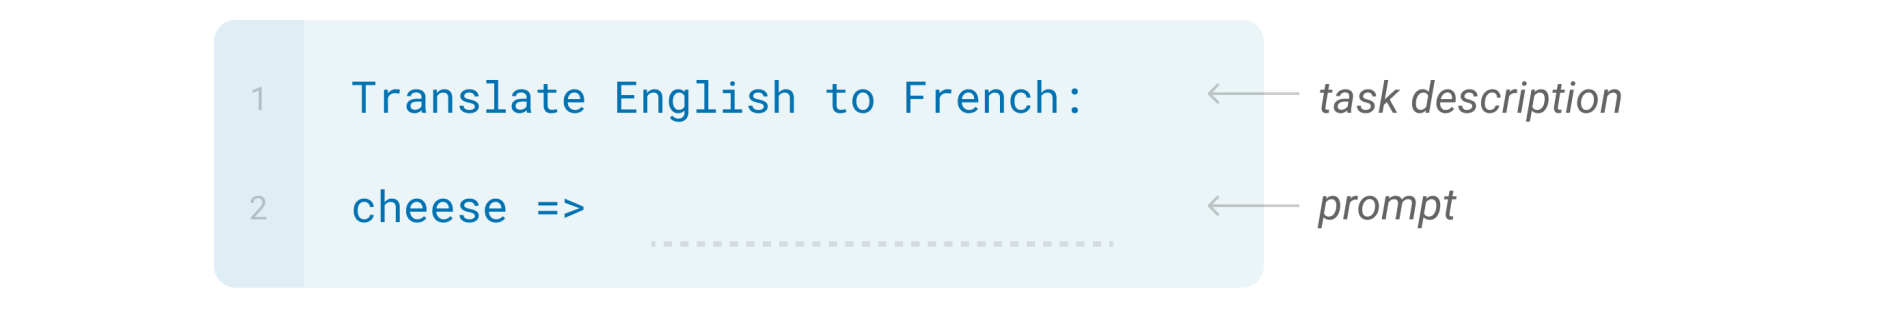

2. One-Shot - вдобавок к самому заданию модель видит один из примеров решения

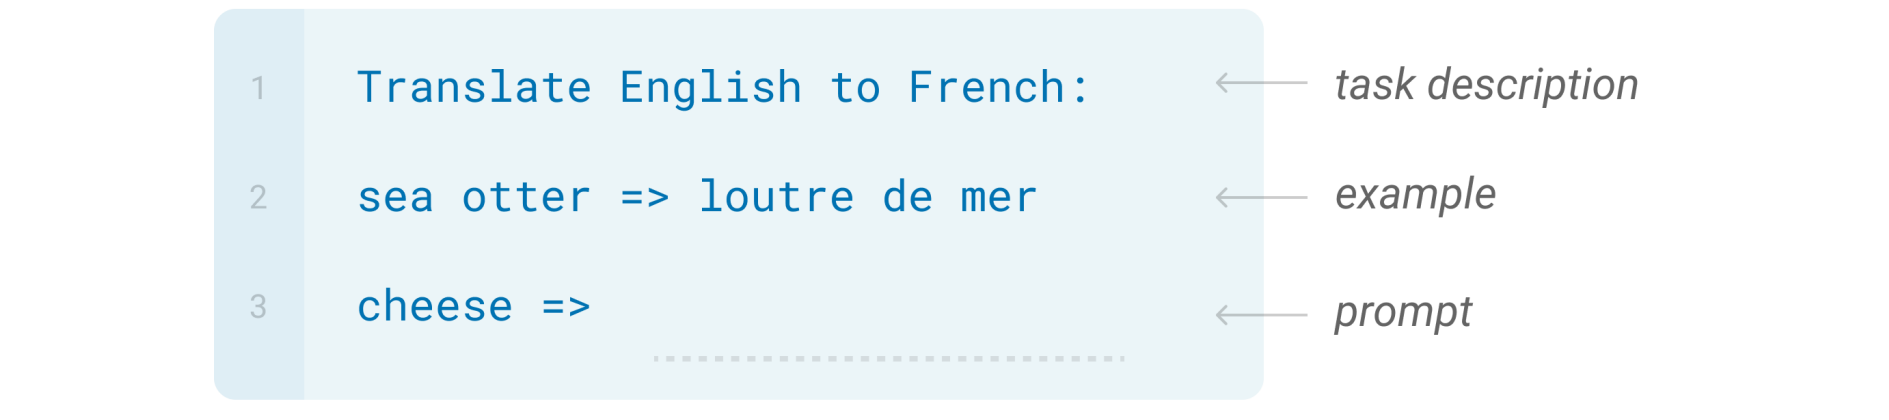

3. Few-Shot - модель видит несколько примеров решения

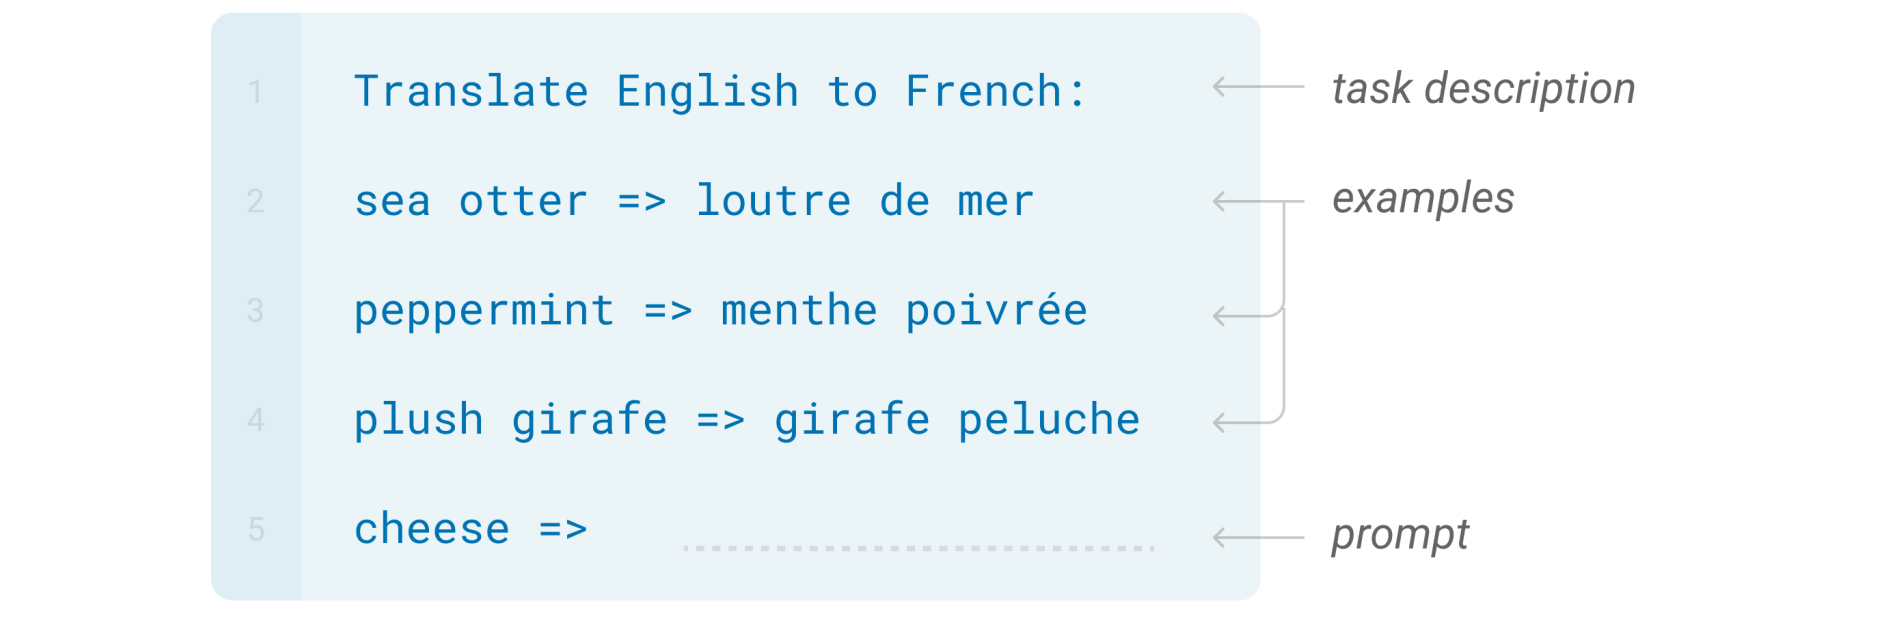

Кроме способности к Zero-Shot / Few-Shot работа модели также опеределяется:
1. Затратами на обучение: насколько эффективную модель можно обучить при фиксированных ресурсах на обучение
2. Эффективность инференса: насколько умную модель можно обучить при фиксированных ресурсах на инференс

Достоинства GPT:
1. Мы учимся предсказывать 100% токенов в teacher forcing - это очень эффективно с точки зрения скорости сходимости
2. Умеет работать в Zero и Few-Shot

Недостатки:
1. Не использует правый контекст при генерации
2. Не может изменять уже сгенерированные токены
3. Потокенная генерация достаточно долгая

Итоговая метрия почти линейно зависит от размера модели (в данном случае - от числа увиденных токенов) - **scaling law**

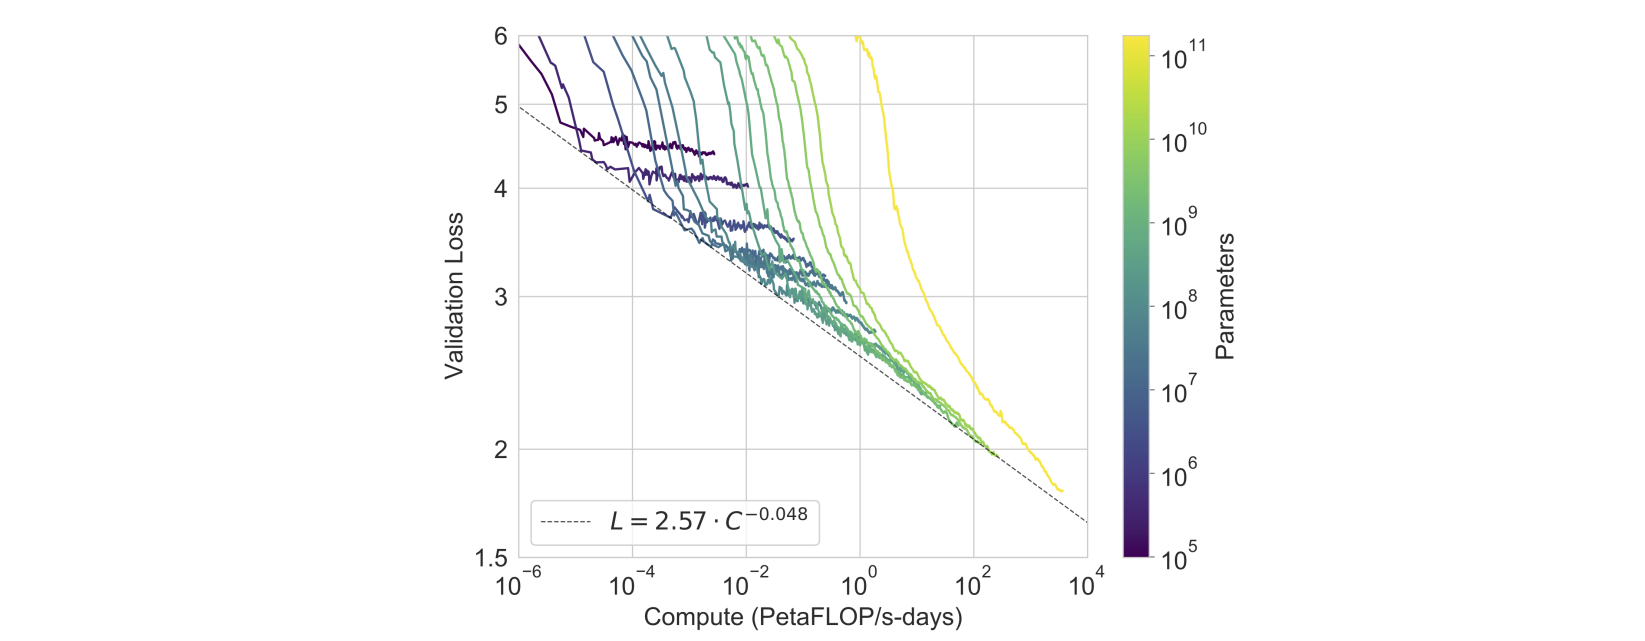

Почему вообще возможен *in-context learning* в Zero & Few-Shot задачах:
1. Трансформерные модели выступают в виде [метаоптимизаторов](https://proceedings.mlr.press/v202/von-oswald23a/von-oswald23a.pdf), выполняющий SGD внутри self-attention слоя
2. Причем число слоев эквивалентно числу шагов оптимизатора, а с течением обучения ранг тензора обновления становится все больше
3. Они не только делают "fine-tune" внутни контекста токенов. FFN в трансформере - аналог [памяти](https://arxiv.org/pdf/2012.14913.pdf) для Key-Value пар.
$$
y^l = \sum_i ReLU(x^lk_i^l)v_i^l + b^l
$$
Поэтому метаоптимизация идет по всей памяти, а чем глубже и шире архитектура, тем ее больше  

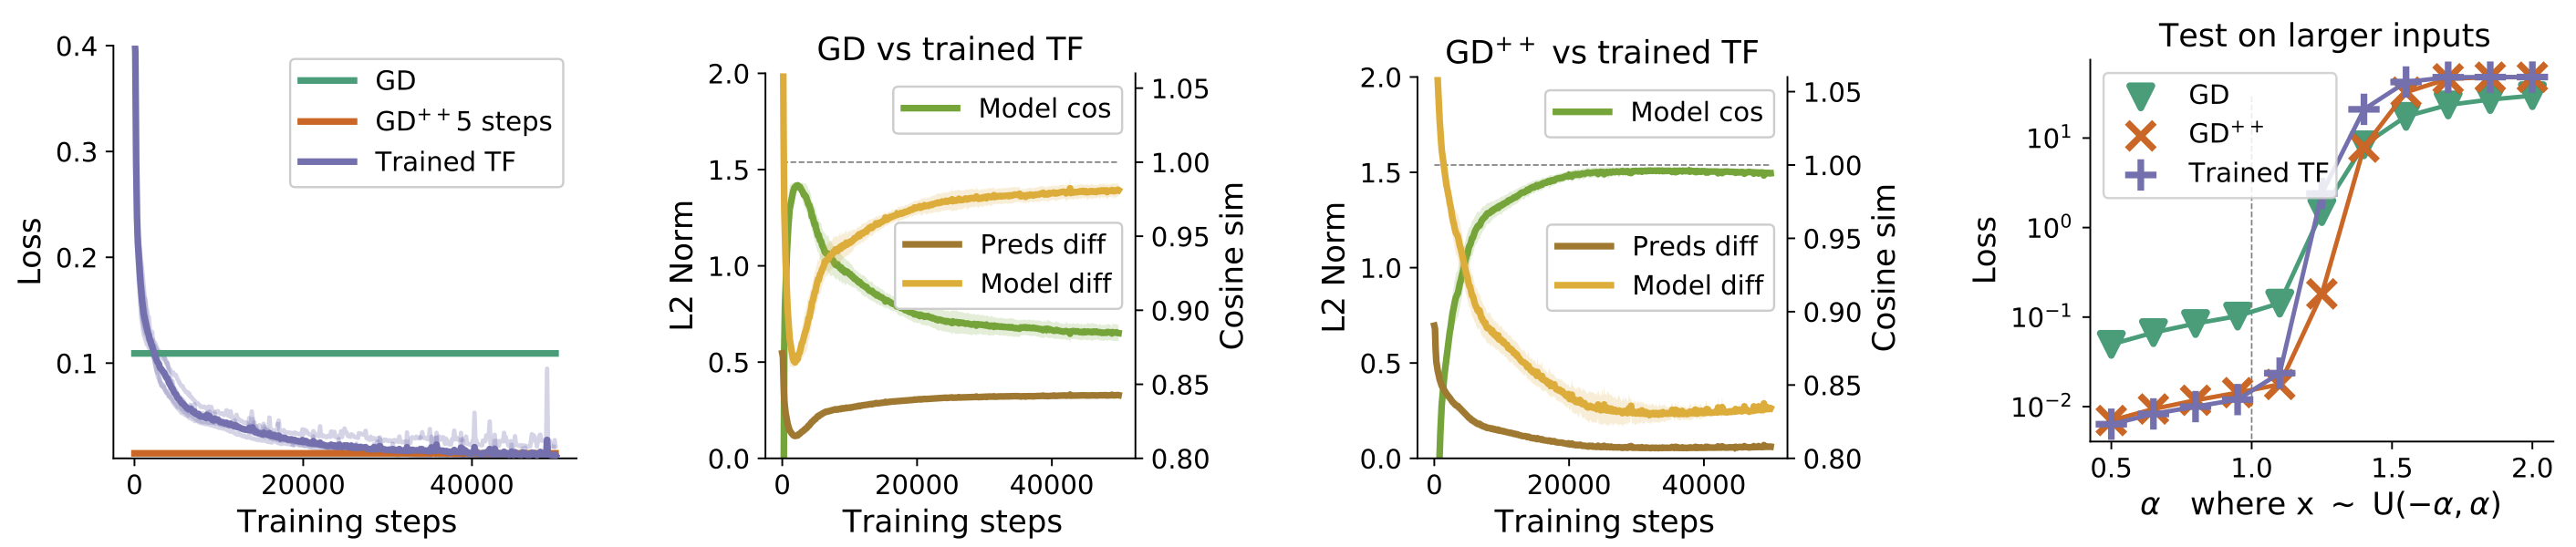

# Полный Transformer: T5

Многие задачи можно сформулировать в виде sequence-to-sequence: классификация, перевод, распознавание именованных сущностей, языковое моделирование, суммаризация

Достоинства:
1. Благодаря энкодеру могут более точно поддерживать контекст
2. Быстрее, чем decoder-only, потому что можно сделать декодер небольшим за счет большого энкодера (как, например, в DistillWhisper)

# Введение в LLM

Доп.материалы:
https://youtu.be/kCc8FmEb1nY?si=SJDpFxi7JHTpbPVw

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
import torch
import torch.nn.functional as F


context = "Why the sky is blue?"
# context = "The students"
# context = "Give me a short introduction to large language model."
for step in range(15):
    inputs = tokenizer(context, return_tensors="pt").to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits / 1.0
    probs = F.softmax(logits[0, -1, :], dim=-1)
    next_id = torch.multinomial(probs, num_samples=1).item()
    next_token = tokenizer.decode(next_id)
    print(f"Step {step+1}: {next_token.strip()} (p={probs[next_id]:.3f})")
    context += tokenizer.decode([next_id])

print(context)


Step 1: Answer (p=0.005)
Step 2: according (p=0.459)
Step 3: to (p=1.000)
Step 4: : (p=0.820)
Step 5: “ (p=0.008)
Step 6: O (p=0.002)
Step 7: of (p=0.002)
Step 8: , (p=0.275)
Step 9: how (p=0.035)
Step 10: is (p=0.040)
Step 11: it (p=0.416)
Step 12: , (p=0.028)
Step 13: how (p=0.034)
Step 14: is (p=0.316)
Step 15: it (p=0.824)
Why the sky is blue? Answer according to: “Oof, how is it, how is it


In [ ]:
import torch
import torch.nn.functional as F


# context = "Why the sky is blue?"
# context = "The students"
context = "Give me a short introduction to large language model."
inputs = tokenizer(context, return_tensors="pt").to("cuda")
with torch.no_grad():
    logits = model(**inputs).logits
probs = F.softmax(logits[0, -1, :], dim=-1)
sorted_probs, sorted_indices = torch.sort(probs, descending=True)

top_k = 20
for i in range(top_k):
    token_id = sorted_indices[i].item()
    token_str = tokenizer.decode([token_id])
    prob = sorted_probs[i].item()
    print(f"{i+1:2d}. {repr(token_str):15s}  p={prob:.4f}")



 1. ' A'             p=0.3223
 2. ' Large'         p=0.1729
 3. ' What'          p=0.0361
 4. ' The'           p=0.0320
 5. ' Sure'          p=0.0220
 6. ' I'             p=0.0171
 7. ' '              p=0.0142
 8. ' a'             p=0.0125
 9. ' Certainly'     p=0.0125
10. ' Please'        p=0.0117
11. ' large'         p=0.0104
12. ' -'             p=0.0092
13. ' This'          p=0.0076
14. ' #'             p=0.0071
15. ' "'             p=0.0067
16. ' L'             p=0.0067
17. ' An'            p=0.0067
18. ' It'            p=0.0063
19. ' You'           p=0.0063
20. ' How'           p=0.0063


### Методы семплирования

Greedy Search - на каждом шаге всегда выбирается слово с самой высокой вероятностью.

Top-k Sampling - составляет короткий список из k наиболее вероятных кандидатов, а затем случайным образом выбирает одно слово уже из этого списка. Случайность позволяет создавать более интересные и вариативные тексты. Однако фиксированный размер k может быть недостатком. При остром распределении вероятностей в выборку могут не попасть хорошие варианты, при плоском, наоборот, попасть неудачные.

Top-p (ядерная) выборка - размер списка не фиксирован, а динамически определяется на основе кумулятивной вероятности. Отбираются самые вероятные слова, сумма вероятностей которых достигает заданного порога p, что позволяет адаптивно управлять разнообразием в зависимости от уверенности модели.

In [ ]:
temperatures = [0.5, 1.0, 1000.0]
context = "Give me a short introduction to large language model."

for t in temperatures:
  print(f"Temperature is {t}")
  inputs = tokenizer(context, return_tensors="pt").to("cuda")
  with torch.no_grad():
      logits = model(**inputs).logits / t

  probs = F.softmax(logits[0, -1, :], dim=-1)
  sorted_probs, sorted_indices = torch.sort(probs, descending=True)

  top_k = 20
  for i in range(top_k):
      token_id = sorted_indices[i].item()
      token_str = tokenizer.decode([token_id])
      prob = sorted_probs[i].item()
      print(f"{i+1:2d}. {repr(token_str):15s}  p={prob:.4f}")
  print()

Temperature is 0.5
 1. ' A'             p=0.7500
 2. ' Large'         p=0.2148
 3. ' What'          p=0.0095
 4. ' The'           p=0.0074
 5. ' Sure'          p=0.0035
 6. ' I'             p=0.0021
 7. ' '              p=0.0014
 8. ' a'             p=0.0011
 9. ' Certainly'     p=0.0011
10. ' Please'        p=0.0010
11. ' large'         p=0.0008
12. ' -'             p=0.0006
13. ' This'          p=0.0004
14. ' #'             p=0.0004
15. ' "'             p=0.0003
16. ' L'             p=0.0003
17. ' An'            p=0.0003
18. ' It'            p=0.0003
19. ' You'           p=0.0003
20. ' How'           p=0.0003

Temperature is 1.0
 1. ' A'             p=0.3223
 2. ' Large'         p=0.1729
 3. ' What'          p=0.0361
 4. ' The'           p=0.0320
 5. ' Sure'          p=0.0220
 6. ' I'             p=0.0171
 7. ' '              p=0.0142
 8. ' a'             p=0.0125
 9. ' Certainly'     p=0.0125
10. ' Please'        p=0.0117
11. ' large'         p=0.0104
12. ' -'             p=0.0092
1

### Instruct модели

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print(text)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Give me a short introduction to large language model.<|im_end|>
<|im_start|>assistant

Large language models (LLMs) are artificial intelligence systems that use deep learning algorithms to generate human-like text. These models can be trained on vast amounts of data and learn complex patterns in language using techniques such as transformer architecture, which has been shown to outperform traditional machine learning approaches.

LLMs have the potential to revolutionize various fields, including natural language processing, chatbots, virtual assistants, and more. They can process large volumes of information quickly and accurately, making them highly effective tools for tasks like language translation, summarization, and question-answering.

However, LLMs also pose challenges related to their accuracy and interpretability, as they often rely on large datasets and sophistic